## OffsetView Op

In [1]:
//load ImageJ
%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-67

//create ImageJ object
ij = new net.imagej.ImageJ()

Added new repo: scijava.public


net.imagej.ImageJ@449a6db1

   This `Op` wraps the `Views.offset()` method of ImgLib2, translating any `RandomAcessible` by a given `offset`. Let's see how the `Op` is called:

In [2]:
ij.op().help('offsetView')

Available operations:
	(MixedTransformView out) =
	net.imagej.ops.transform.offsetView.DefaultOffsetView(
		RandomAccessible in,
		long[] offset)
	(IntervalView out) =
	net.imagej.ops.transform.offsetView.OffsetViewInterval(
		RandomAccessible in,
		Interval interval)
	(IntervalView out) =
	net.imagej.ops.transform.offsetView.OffsetViewOriginSize(
		RandomAccessible in,
		long[] origin,
		long[] dimension)

Note that there are three different `offsetView` options, so let's look at how each differs, based on their exclusive parameters:

* `long[] offset`: This `long[]` translates the `RandomAccessible` by `-offset`, such that the pixel at `offset` on the input is at the origin on the output `MixedTransformView`. This is the only `offsetView` `Op` that returns a `View` not on an `Interval`.

* `Interval interval`: This `offsetView` `Op` takes in an interval on a `RandomAccessible` and returns an `IntervalView` on that `RandomAccessible` where the minimum of the `IntervalView` is `(0, ... , 0)`. This `Op` is similar to the above `Op` but only returns an `Interval` of the output. **NOTE**: all the pixels within the `Interval` **must** be defined within the `RandomAccessible`.

* `long[] origin, long[] dimension`: This `Op` is very similar to the one defined by the `Interval`, however it creates the `Interval` itself such that the `Interval` has its origin (`min`) at `long[] origin` and has its `max` at `(origin[0] + dimension[0], ... , origin[n] + dimension[n])`. In other words, the `Interval` will have the size of `dimensions[]` and will start from `origin[]` on the input, but the output `IntervalView` will have `min[] = (0, ... 0)`. **NOTE**: all the pixels within the `Interval` **must** be defined within the `RandomAccessible`.

Let's look at the second option in this tutorial. We need an `Img`:

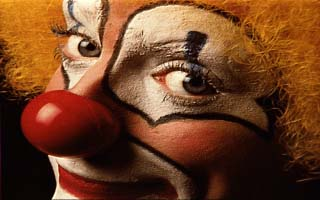

In [3]:
input = ij.scifio().datasetIO().open("http://imagej.net/images/clown.png")

ij.notebook().display(input)

Let's translate this clown 50 pixels away from the origin in both width and height. Note that our image is 3-dimensional but because we don't want to screw up the colors we will have to pass through an `offset` of size `3` where the third element is `0`. Let's create an `Interval` using `FinalInterval.createMinSize()` (a method that takes `2n` parameters, where the first `n` are the minimum of the interval and the second `n` are the size).

In [4]:
import net.imglib2.FinalInterval

w = input.dimension(0)
h = input.dimension(1)
interval = FinalInterval.createMinSize(-50, -50, 0, w, h, 3)

net.imglib2.FinalInterval@45d08d2f

Note that in the description above all pixels within our `Interval` have to be defined. However because we are shifting away from the origin all of the pixels with a negative coordinate will not be defined. Thus we first have to extend our `Img`. Let's use [`extendRandomView`](extendRandomView.ipynb) so that we can easily tell which pixels are new. And then, once we have our `Img` defined everywhere we can pass the `Img` and the `Interval` to `offsetView()`:

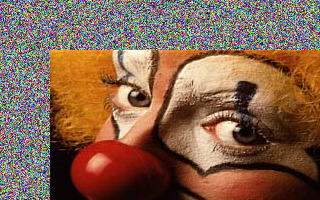

In [5]:
typeMin = input.firstElement().getMinValue()
typeMax = input.firstElement().getMaxValue()
extended = ij.op().run("extendRandomView", input, typeMin, typeMax)

offset = ij.op().run("offsetView", extended, interval)

ij.notebook().display(offset)

Note that this `Op` is very similar to [`translateView`](translateView.ipynb), however there is one key difference: `offsetView` only moves the image data, **not** the bounds of your image. `translateView`, however, also moves the image bounds along with your data, which is why there is no visual difference on the translated image above. This is what happens to our clown when we run `translateView`:

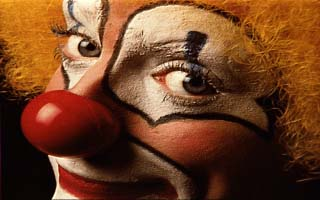

In [6]:
//move the same offset as the interval two code cells above
translation = [-50, -50, 0] as long[]

translated = ij.op().run("translateView", input, translation)

ij.notebook().display(translated)

There is no visual difference with `translateView`, however if we interrogate the minimum of each image we can see the difference between the `Op`s:

In [7]:
"minimum of offset image: (" + offset.min(0) + ", " + offset.min(1) + ")\n" + 
"minimum of translated image: (" + translated.min(0) + ", " + translated.min(1) + ")"

minimum of offset image: (0, 0)
minimum of translated image: (-50, -50)